# Phase 1: Distance Threshold Analysis

Analyzes experiment results to determine an optimal cosine distance cutoff for filtering
retrieved memories. The goal is to increase **precision** (reduce false positives) while
maintaining acceptable **recall** (not losing ground truth memories).

**Two analysis levels:**
1. **Per-result level** — every `(distance, is_ground_truth)` data point from query results
2. **Per-memory level** — deduplicated by memory ID, using the *best* (minimum) distance across all queries. This reflects how the system actually works: a memory is "found" if *any* query retrieves it.

**Approach:**
1. Collect distance data at both levels
2. Visualize distributions (ground truth vs non-ground-truth)
3. Sweep thresholds and compute precision/recall/F1
4. Identify the optimal cutoff and its tradeoffs

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

RESULTS_DIR = Path("../data/phase1/results")

# Load all experiment result files
result_files = sorted(RESULTS_DIR.glob("results_*.json"))
print(f"Found {len(result_files)} result files:")
for f in result_files:
    print(f"  {f.name}")

Found 5 result files:
  results_tc_bugfix-VAPI-766-to-release-v1-32-1_exp_20260129_182520.json
  results_tc_feature-VAPI-561-be-datasource-mock-planningscope-to-release-v1-33-0-with-diff_exp_20260129_182537.json
  results_tc_feature-VAPI-652-to-release-v1-33-0_exp_20260129_182555.json
  results_tc_feature-VAPI-724-to-release-v1-33-0_exp_20260129_182610.json
  results_tc_feature-VAPI-732-be-multiple-auth-strategies-on-endpoint-8h-to-release-v1-33-0_exp_20260129_182628.json


In [2]:
# Extract all (distance, is_ground_truth) pairs from every query result
gt_distances = []       # distances where result IS ground truth
non_gt_distances = []   # distances where result is NOT ground truth
all_points = []         # (distance, is_gt, test_case_id, query_index)

experiments = []
for f in result_files:
    with open(f) as fh:
        data = json.load(fh)
    experiments.append(data)
    tc_id = data.get("test_case_id", f.stem)

    for qi, qr in enumerate(data.get("queries", [])):
        for r in qr.get("results", []):
            d = r["distance"]
            is_gt = r["is_ground_truth"]
            all_points.append((d, is_gt, tc_id, qi))
            if is_gt:
                gt_distances.append(d)
            else:
                non_gt_distances.append(d)

gt_distances = np.array(gt_distances)
non_gt_distances = np.array(non_gt_distances)

print(f"Total data points: {len(all_points)}")
print(f"  Ground truth hits: {len(gt_distances)}")
print(f"  Non-ground-truth:  {len(non_gt_distances)}")
print(f"\nGround truth distance range: [{gt_distances.min():.4f}, {gt_distances.max():.4f}]")
print(f"Non-GT distance range:       [{non_gt_distances.min():.4f}, {non_gt_distances.max():.4f}]")
print(f"\nGround truth mean: {gt_distances.mean():.4f}, median: {np.median(gt_distances):.4f}")
print(f"Non-GT mean:       {non_gt_distances.mean():.4f}, median: {np.median(non_gt_distances):.4f}")

Total data points: 235
  Ground truth hits: 83
  Non-ground-truth:  152

Ground truth distance range: [0.4736, 1.0158]
Non-GT distance range:       [0.7124, 1.0107]

Ground truth mean: 0.8464, median: 0.8715
Non-GT mean:       0.8951, median: 0.8996


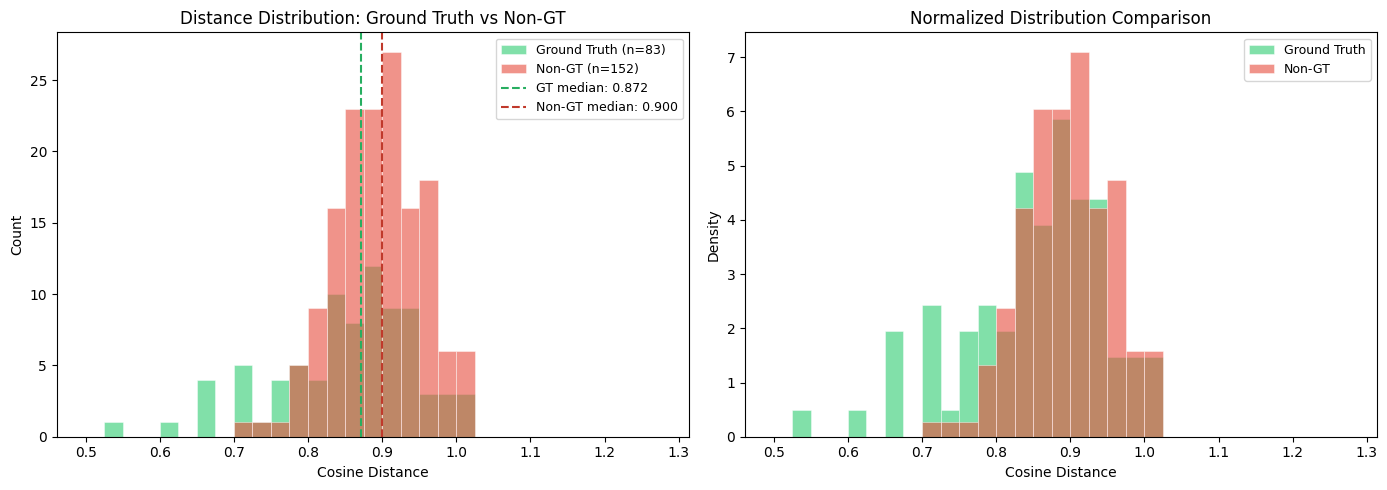

In [3]:
# Plot overlaid histograms of distance distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: overlaid histograms
bins = np.arange(0.5, 1.3, 0.025)
axes[0].hist(gt_distances, bins=bins, alpha=0.6, label=f"Ground Truth (n={len(gt_distances)})",
             color="#2ecc71", edgecolor="white", linewidth=0.5)
axes[0].hist(non_gt_distances, bins=bins, alpha=0.6, label=f"Non-GT (n={len(non_gt_distances)})",
             color="#e74c3c", edgecolor="white", linewidth=0.5)
axes[0].axvline(np.median(gt_distances), color="#27ae60", linestyle="--", linewidth=1.5,
                label=f"GT median: {np.median(gt_distances):.3f}")
axes[0].axvline(np.median(non_gt_distances), color="#c0392b", linestyle="--", linewidth=1.5,
                label=f"Non-GT median: {np.median(non_gt_distances):.3f}")
axes[0].set_xlabel("Cosine Distance")
axes[0].set_ylabel("Count")
axes[0].set_title("Distance Distribution: Ground Truth vs Non-GT")
axes[0].legend(fontsize=9)

# Right: KDE-style comparison using normalized histograms
axes[1].hist(gt_distances, bins=bins, alpha=0.6, density=True,
             label="Ground Truth", color="#2ecc71", edgecolor="white", linewidth=0.5)
axes[1].hist(non_gt_distances, bins=bins, alpha=0.6, density=True,
             label="Non-GT", color="#e74c3c", edgecolor="white", linewidth=0.5)
axes[1].set_xlabel("Cosine Distance")
axes[1].set_ylabel("Density")
axes[1].set_title("Normalized Distribution Comparison")
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
# Sweep distance thresholds and compute precision/recall/F1
# A result is "accepted" if distance <= threshold
# Precision = GT accepted / total accepted
# Recall = GT accepted / total GT

thresholds = np.arange(0.50, 1.25, 0.01)
precisions = []
recalls = []
f1_scores = []
n_accepted = []

total_gt = len(gt_distances)

for t in thresholds:
    gt_accepted = np.sum(gt_distances <= t)
    non_gt_accepted = np.sum(non_gt_distances <= t)
    total_accepted = gt_accepted + non_gt_accepted

    p = gt_accepted / total_accepted if total_accepted > 0 else 1.0
    r = gt_accepted / total_gt if total_gt > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0

    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1)
    n_accepted.append(total_accepted)

precisions = np.array(precisions)
recalls = np.array(recalls)
f1_scores = np.array(f1_scores)
n_accepted = np.array(n_accepted)

# Find optimal F1 threshold
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
print(f"Optimal F1 threshold: {best_threshold:.2f}")
print(f"  F1:        {f1_scores[best_f1_idx]:.3f}")
print(f"  Precision: {precisions[best_f1_idx]:.3f}")
print(f"  Recall:    {recalls[best_f1_idx]:.3f}")
print(f"  Accepted:  {n_accepted[best_f1_idx]} / {len(all_points)} results")

Optimal F1 threshold: 0.94
  F1:        0.531
  Precision: 0.383
  Recall:    0.867
  Accepted:  188 / 235 results


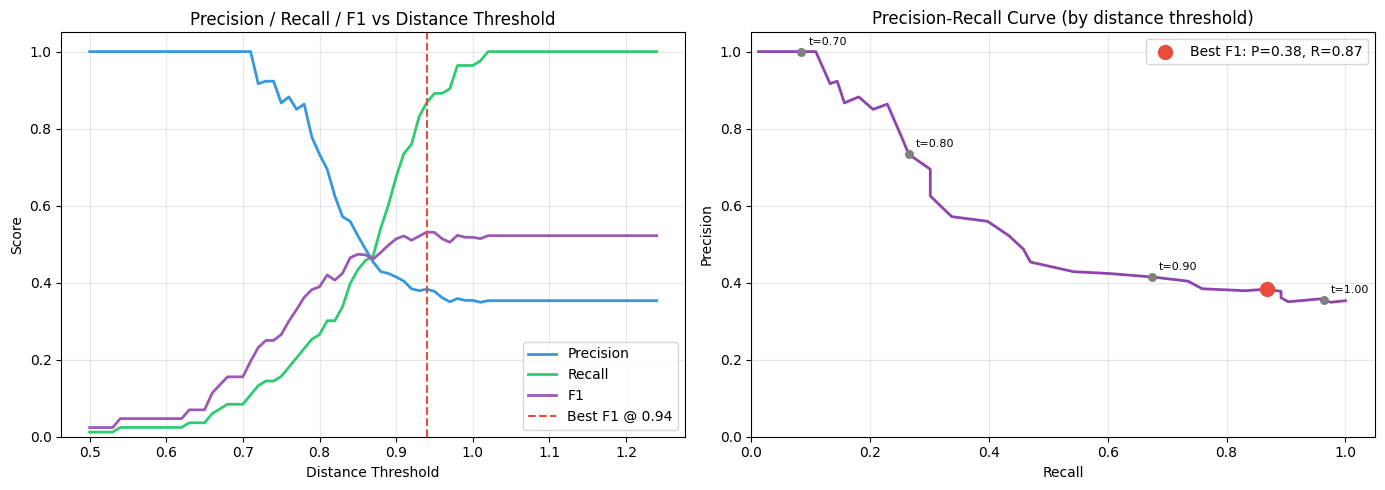

In [5]:
# Plot Precision/Recall/F1 vs threshold
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: P/R/F1 vs threshold
axes[0].plot(thresholds, precisions, label="Precision", color="#3498db", linewidth=2)
axes[0].plot(thresholds, recalls, label="Recall", color="#2ecc71", linewidth=2)
axes[0].plot(thresholds, f1_scores, label="F1", color="#9b59b6", linewidth=2)
axes[0].axvline(best_threshold, color="#e74c3c", linestyle="--", linewidth=1.5,
                label=f"Best F1 @ {best_threshold:.2f}")
axes[0].set_xlabel("Distance Threshold")
axes[0].set_ylabel("Score")
axes[0].set_title("Precision / Recall / F1 vs Distance Threshold")
axes[0].legend()
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3)

# Right: Precision-Recall curve
axes[1].plot(recalls, precisions, color="#8e44ad", linewidth=2)
axes[1].scatter([recalls[best_f1_idx]], [precisions[best_f1_idx]],
               color="#e74c3c", s=100, zorder=5,
               label=f"Best F1: P={precisions[best_f1_idx]:.2f}, R={recalls[best_f1_idx]:.2f}")
# Annotate a few threshold values along the curve
for t_val in [0.70, 0.80, 0.90, 1.00]:
    idx = np.argmin(np.abs(thresholds - t_val))
    axes[1].annotate(f"t={t_val:.2f}",
                     xy=(recalls[idx], precisions[idx]),
                     fontsize=8, ha="left",
                     xytext=(5, 5), textcoords="offset points")
    axes[1].scatter([recalls[idx]], [precisions[idx]], color="gray", s=30, zorder=4)

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve (by distance threshold)")
axes[1].legend()
axes[1].set_xlim(0, 1.05)
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Detailed table of metrics at key thresholds
key_thresholds = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.10, 1.20]

print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'Accepted':>10} {'GT Kept':>8} {'GT Lost':>8}")
print("-" * 74)

for t in key_thresholds:
    gt_accepted = int(np.sum(gt_distances <= t))
    non_gt_accepted = int(np.sum(non_gt_distances <= t))
    total_accepted = gt_accepted + non_gt_accepted

    p = gt_accepted / total_accepted if total_accepted > 0 else 1.0
    r = gt_accepted / total_gt if total_gt > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0

    gt_lost = total_gt - gt_accepted
    marker = " <-- best F1" if abs(t - best_threshold) < 0.005 else ""
    print(f"{t:>10.2f} {p:>10.3f} {r:>8.3f} {f1:>8.3f} {total_accepted:>10} {gt_accepted:>8} {gt_lost:>8}{marker}")

 Threshold  Precision   Recall       F1   Accepted  GT Kept  GT Lost
--------------------------------------------------------------------------
      0.65      1.000    0.036    0.070          3        3       80
      0.70      1.000    0.084    0.156          7        7       76
      0.75      0.867    0.157    0.265         15       13       70
      0.80      0.733    0.265    0.389         30       22       61
      0.85      0.522    0.434    0.474         69       36       47
      0.90      0.415    0.675    0.514        135       56       27
      0.95      0.378    0.892    0.530        196       74        9
      1.00      0.354    0.964    0.518        226       80        3
      1.10      0.353    1.000    0.522        235       83        0
      1.20      0.353    1.000    0.522        235       83        0


## Experiment-Level Analysis (Best Distance Per Unique Memory)

The per-result view above counts each query→result pair independently. But in practice, a memory is
"found" if **any** query retrieves it. This section deduplicates by memory ID and uses the minimum
distance across all queries — this is the metric that determines whether a memory passes the threshold.

In [7]:
# Build per-unique-memory data: best (minimum) distance for each memory across all queries
gt_best_distances = []     # best distance per GT memory (across all experiments)
non_gt_best_distances = [] # best distance per non-GT memory
gt_memory_details = []     # (memory_id, best_distance, experiment_id)

for exp in experiments:
    tc_id = exp.get("test_case_id", "unknown")
    gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))

    best_distances = {}
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            mid = r["id"]
            d = r["distance"]
            if mid not in best_distances or d < best_distances[mid]:
                best_distances[mid] = d

    for mid, d in best_distances.items():
        if mid in gt_ids:
            gt_best_distances.append(d)
            gt_memory_details.append((mid, d, tc_id))
        else:
            non_gt_best_distances.append(d)

gt_best = np.array(gt_best_distances)
non_gt_best = np.array(non_gt_best_distances)

# Count GT memories NOT retrieved at all
total_gt_memories = sum(len(exp.get("ground_truth", {}).get("memory_ids", [])) for exp in experiments)
not_retrieved = total_gt_memories - len(gt_best)

print(f"Unique memories retrieved across all experiments:")
print(f"  GT memories retrieved:     {len(gt_best)} / {total_gt_memories}")
print(f"  GT memories NOT retrieved: {not_retrieved}")
print(f"  Non-GT memories:           {len(non_gt_best)}")
print(f"\nGT best-distance range:     [{gt_best.min():.4f}, {gt_best.max():.4f}]")
print(f"Non-GT best-distance range: [{non_gt_best.min():.4f}, {non_gt_best.max():.4f}]")
print(f"\nGT mean: {gt_best.mean():.4f}, median: {np.median(gt_best):.4f}")
print(f"Non-GT mean: {non_gt_best.mean():.4f}, median: {np.median(non_gt_best):.4f}")

print(f"\nPer GT memory details (sorted by distance):")
for mid, d, tc in sorted(gt_memory_details, key=lambda x: x[1]):
    print(f"  {d:.4f}  {mid}  ({tc})")

Unique memories retrieved across all experiments:
  GT memories retrieved:     14 / 15
  GT memories NOT retrieved: 1
  Non-GT memories:           44

GT best-distance range:     [0.4736, 0.9288]
Non-GT best-distance range: [0.7124, 1.0057]

GT mean: 0.7507, median: 0.7720
Non-GT mean: 0.8615, median: 0.8616

Per GT memory details (sorted by distance):
  0.4736  mem_27c0790028fb  (tc_feature-VAPI-652-to-release-v1-33-0)
  0.5399  mem_9ac174a1bdca  (tc_feature-VAPI-724-to-release-v1-33-0)
  0.6522  mem_3ff713d80604  (tc_bugfix-VAPI-766-to-release-v1-32-1)
  0.6579  mem_be4484aa9836  (tc_feature-VAPI-732-be-multiple-auth-strategies-on-endpoint-8h-to-release-v1-33-0)
  0.7061  mem_67b4f176fe7c  (tc_feature-VAPI-724-to-release-v1-33-0)
  0.7141  mem_2d01622ee7e8  (tc_bugfix-VAPI-766-to-release-v1-32-1)
  0.7676  mem_8c09610c6123  (tc_bugfix-VAPI-766-to-release-v1-32-1)
  0.7763  mem_7847dca3ec16  (tc_feature-VAPI-652-to-release-v1-33-0)
  0.8054  mem_5ecde6c3aebe  (tc_feature-VAPI-732-be-m

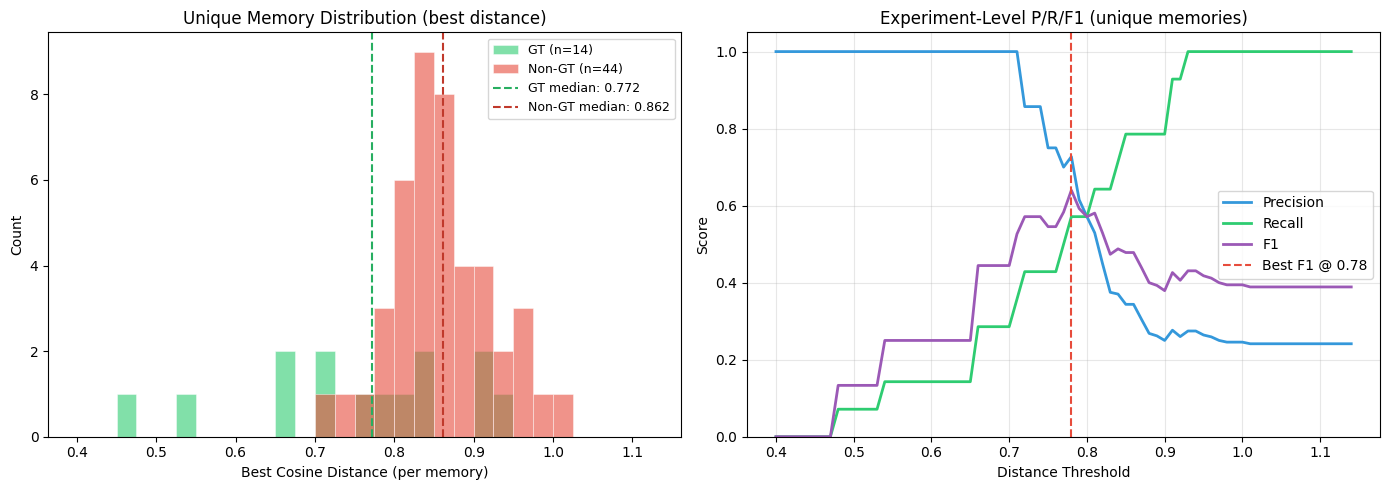


Experiment-level optimal F1 threshold: 0.78
  F1:        0.640
  Precision: 0.727
  Recall:    0.571


In [8]:
# Experiment-level histograms and threshold sweep
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bins = np.arange(0.4, 1.15, 0.025)

# Left: overlaid histograms (unique memories, best distance)
axes[0].hist(gt_best, bins=bins, alpha=0.6, label=f"GT (n={len(gt_best)})",
             color="#2ecc71", edgecolor="white", linewidth=0.5)
axes[0].hist(non_gt_best, bins=bins, alpha=0.6, label=f"Non-GT (n={len(non_gt_best)})",
             color="#e74c3c", edgecolor="white", linewidth=0.5)
axes[0].axvline(np.median(gt_best), color="#27ae60", linestyle="--", linewidth=1.5,
                label=f"GT median: {np.median(gt_best):.3f}")
axes[0].axvline(np.median(non_gt_best), color="#c0392b", linestyle="--", linewidth=1.5,
                label=f"Non-GT median: {np.median(non_gt_best):.3f}")
axes[0].set_xlabel("Best Cosine Distance (per memory)")
axes[0].set_ylabel("Count")
axes[0].set_title("Unique Memory Distribution (best distance)")
axes[0].legend(fontsize=9)

# Right: P/R/F1 vs threshold (experiment level)
exp_thresholds = np.arange(0.40, 1.15, 0.01)
exp_precisions = []
exp_recalls = []
exp_f1_scores = []
exp_total_gt = len(gt_best)

for t in exp_thresholds:
    gt_acc = np.sum(gt_best <= t)
    non_gt_acc = np.sum(non_gt_best <= t)
    total_acc = gt_acc + non_gt_acc
    p = gt_acc / total_acc if total_acc > 0 else 1.0
    r = gt_acc / exp_total_gt if exp_total_gt > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    exp_precisions.append(p)
    exp_recalls.append(r)
    exp_f1_scores.append(f1)

exp_precisions = np.array(exp_precisions)
exp_recalls = np.array(exp_recalls)
exp_f1_scores = np.array(exp_f1_scores)

exp_best_f1_idx = np.argmax(exp_f1_scores)
exp_best_threshold = exp_thresholds[exp_best_f1_idx]

axes[1].plot(exp_thresholds, exp_precisions, label="Precision", color="#3498db", linewidth=2)
axes[1].plot(exp_thresholds, exp_recalls, label="Recall", color="#2ecc71", linewidth=2)
axes[1].plot(exp_thresholds, exp_f1_scores, label="F1", color="#9b59b6", linewidth=2)
axes[1].axvline(exp_best_threshold, color="#e74c3c", linestyle="--", linewidth=1.5,
                label=f"Best F1 @ {exp_best_threshold:.2f}")
axes[1].set_xlabel("Distance Threshold")
axes[1].set_ylabel("Score")
axes[1].set_title("Experiment-Level P/R/F1 (unique memories)")
axes[1].legend()
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExperiment-level optimal F1 threshold: {exp_best_threshold:.2f}")
print(f"  F1:        {exp_f1_scores[exp_best_f1_idx]:.3f}")
print(f"  Precision: {exp_precisions[exp_best_f1_idx]:.3f}")
print(f"  Recall:    {exp_recalls[exp_best_f1_idx]:.3f}")

In [9]:
# Experiment-level threshold table (unique memories)
print(f"Experiment-level threshold table (unique memories, best distance per memory):\n")
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'Accepted':>10} {'GT Kept':>8} {'GT Lost':>8}")
print("-" * 74)

for t in [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.05]:
    gt_acc = int(np.sum(gt_best <= t))
    non_gt_acc = int(np.sum(non_gt_best <= t))
    total_acc = gt_acc + non_gt_acc
    p = gt_acc / total_acc if total_acc > 0 else 1.0
    r = gt_acc / exp_total_gt if exp_total_gt > 0 else 0.0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    gt_lost = exp_total_gt - gt_acc
    marker = " <--" if abs(t - exp_best_threshold) < 0.015 else ""
    print(f"{t:>10.2f} {p:>10.3f} {r:>8.3f} {f1:>8.3f} {total_acc:>10} {gt_acc:>8} {gt_lost:>8}{marker}")

Experiment-level threshold table (unique memories, best distance per memory):

 Threshold  Precision   Recall       F1   Accepted  GT Kept  GT Lost
--------------------------------------------------------------------------
      0.55      1.000    0.143    0.250          2        2       12
      0.60      1.000    0.143    0.250          2        2       12
      0.65      1.000    0.143    0.250          2        2       12
      0.70      1.000    0.286    0.444          4        4       10
      0.75      0.750    0.429    0.545          8        6        8
      0.80      0.571    0.571    0.571         14        8        6
      0.85      0.344    0.786    0.478         32       11        3
      0.90      0.250    0.786    0.379         44       11        3
      0.95      0.264    1.000    0.418         53       14        0
      1.00      0.246    1.000    0.394         57       14        0
      1.05      0.241    1.000    0.389         58       14        0


In [10]:
# Per-experiment impact of applying the best threshold
print(f"Impact of threshold={best_threshold:.2f} per experiment:\n")
print(f"{'Test Case':<55} {'Recall':>7} {'Prec':>7} {'F1':>7} {'GT':>4} {'Kept':>5} {'Lost':>5}")
print("-" * 95)

for exp in experiments:
    tc_id = exp.get("test_case_id", "unknown")
    gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))

    # Collect unique retrieved IDs with their best (minimum) distance
    best_distances = {}  # memory_id -> min distance across all queries
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            mid = r["id"]
            d = r["distance"]
            if mid not in best_distances or d < best_distances[mid]:
                best_distances[mid] = d

    # Apply threshold
    accepted_ids = {mid for mid, d in best_distances.items() if d <= best_threshold}
    gt_accepted = accepted_ids & gt_ids
    gt_lost = gt_ids - accepted_ids

    r = len(gt_accepted) / len(gt_ids) if gt_ids else 0
    p = len(gt_accepted) / len(accepted_ids) if accepted_ids else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0

    print(f"{tc_id:<55} {r:>7.1%} {p:>7.1%} {f1:>7.3f} {len(gt_ids):>4} {len(gt_accepted):>5} {len(gt_lost):>5}")

    if gt_lost:
        for mid in sorted(gt_lost):
            d = best_distances.get(mid)
            d_str = f"{d:.4f}" if d is not None else "NOT RETRIEVED"
            print(f"  {'':55} Lost: {mid} (best d={d_str})")

Impact of threshold=0.94 per experiment:

Test Case                                                Recall    Prec      F1   GT  Kept  Lost
-----------------------------------------------------------------------------------------------
tc_bugfix-VAPI-766-to-release-v1-32-1                    100.0%   30.0%   0.462    3     3     0
tc_feature-VAPI-561-be-datasource-mock-planningscope-to-release-v1-33-0-with-diff  100.0%   22.2%   0.364    2     2     0
tc_feature-VAPI-652-to-release-v1-33-0                   100.0%   22.2%   0.364    2     2     0
tc_feature-VAPI-724-to-release-v1-33-0                   100.0%   27.3%   0.429    3     3     0
tc_feature-VAPI-732-be-multiple-auth-strategies-on-endpoint-8h-to-release-v1-33-0   80.0%   33.3%   0.471    5     4     1
                                                          Lost: mem_39a4da05367a (best d=NOT RETRIEVED)


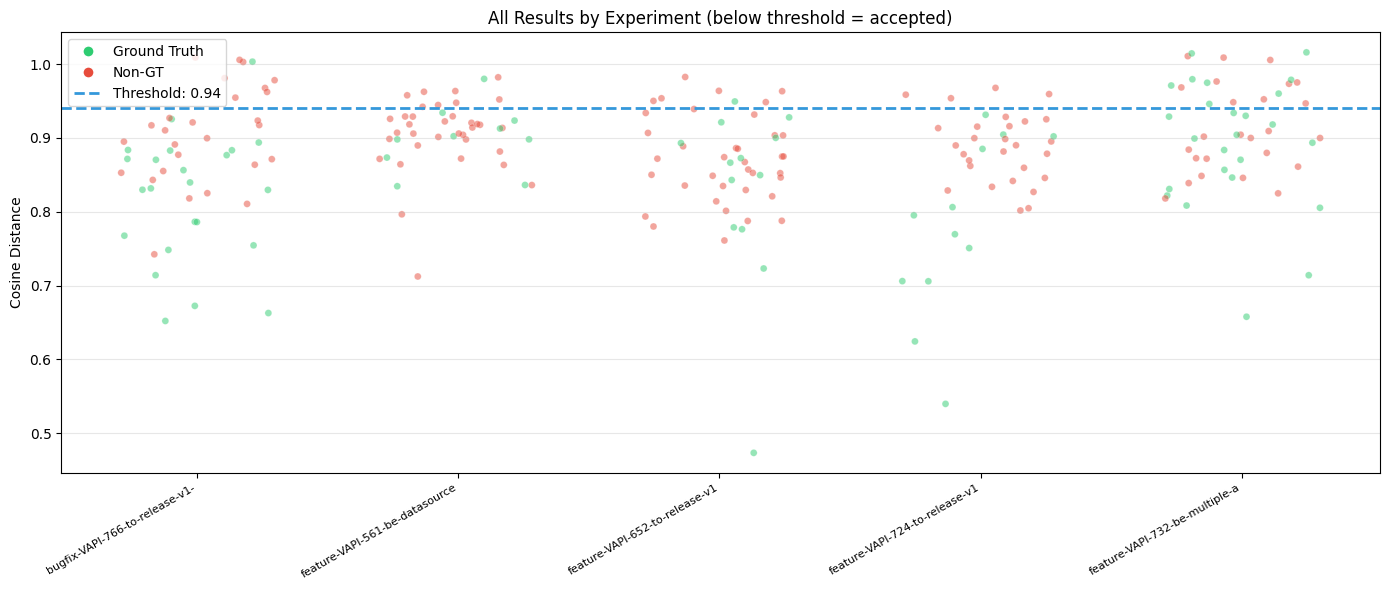

In [11]:
# Scatter plot: every result colored by ground truth status
fig, ax = plt.subplots(figsize=(14, 6))

# Group by experiment for x-axis positioning
exp_names = [e.get("test_case_id", "?").replace("tc_", "")[:30] for e in experiments]
x_positions = []
colors = []
distances_plot = []

for exp_idx, exp in enumerate(experiments):
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            # Add jitter for readability
            x_positions.append(exp_idx + np.random.uniform(-0.3, 0.3))
            distances_plot.append(r["distance"])
            colors.append("#2ecc71" if r["is_ground_truth"] else "#e74c3c")

ax.scatter(x_positions, distances_plot, c=colors, alpha=0.5, s=25, edgecolors="white", linewidth=0.3)
ax.axhline(best_threshold, color="#3498db", linestyle="--", linewidth=2,
           label=f"Optimal threshold: {best_threshold:.2f}")

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=8, label='Ground Truth'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=8, label='Non-GT'),
    Line2D([0], [0], color='#3498db', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold:.2f}'),
]
ax.legend(handles=legend_elements, loc="upper left")

ax.set_xticks(range(len(exp_names)))
ax.set_xticklabels(exp_names, rotation=30, ha="right", fontsize=8)
ax.set_ylabel("Cosine Distance")
ax.set_title("All Results by Experiment (below threshold = accepted)")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [12]:
# Analyze the current confidence buckets from db.py vs data-driven buckets
current_buckets = [
    ("high",     0.0,  0.5),
    ("medium",   0.5,  0.8),
    ("low",      0.8,  1.2),
    ("very_low", 1.2,  2.0),
]

print("Current confidence buckets (db.py) vs actual data:\n")
print(f"{'Bucket':<10} {'Range':<15} {'GT Count':>10} {'Non-GT':>10} {'GT %':>8} {'Precision':>10}")
print("-" * 70)

for name, lo, hi in current_buckets:
    gt_in = int(np.sum((gt_distances >= lo) & (gt_distances < hi)))
    non_gt_in = int(np.sum((non_gt_distances >= lo) & (non_gt_distances < hi)))
    total_in = gt_in + non_gt_in
    gt_pct = gt_in / len(gt_distances) * 100 if len(gt_distances) > 0 else 0
    prec = gt_in / total_in if total_in > 0 else 0
    print(f"{name:<10} [{lo:.1f}, {hi:.1f}){'':<5} {gt_in:>10} {non_gt_in:>10} {gt_pct:>7.1f}% {prec:>10.1%}")

print(f"\nRecommendation: Update confidence buckets based on data distribution.")
print(f"The optimal F1 threshold ({best_threshold:.2f}) should be the cutoff between 'accepted' and 'rejected'.")

Current confidence buckets (db.py) vs actual data:

Bucket     Range             GT Count     Non-GT     GT %  Precision
----------------------------------------------------------------------
high       [0.0, 0.5)               1          0     1.2%     100.0%
medium     [0.5, 0.8)              21          8    25.3%      72.4%
low        [0.8, 1.2)              61        144    73.5%      29.8%
very_low   [1.2, 2.0)               0          0     0.0%       0.0%

Recommendation: Update confidence buckets based on data distribution.
The optimal F1 threshold (0.94) should be the cutoff between 'accepted' and 'rejected'.


In [13]:
# Final summary and recommendation
print("=" * 70)
print("THRESHOLD ANALYSIS SUMMARY")
print("=" * 70)

print(f"\n--- Per-Result Level (raw query results) ---")
print(f"Data points: {len(all_points)} ({len(gt_distances)} GT, {len(non_gt_distances)} non-GT)")
print(f"Optimal F1 threshold: {best_threshold:.2f}")
print(f"  P={precisions[best_f1_idx]:.1%}, R={recalls[best_f1_idx]:.1%}, F1={f1_scores[best_f1_idx]:.3f}")

print(f"\n--- Experiment Level (unique memories, best distance) ---")
print(f"Unique memories: {len(gt_best) + len(non_gt_best)} ({len(gt_best)} GT, {len(non_gt_best)} non-GT)")
print(f"GT not retrieved at all: {not_retrieved}")
print(f"Optimal F1 threshold: {exp_best_threshold:.2f}")
print(f"  P={exp_precisions[exp_best_f1_idx]:.1%}, R={exp_recalls[exp_best_f1_idx]:.1%}, F1={exp_f1_scores[exp_best_f1_idx]:.3f}")

print(f"\n--- Key Tradeoff Points (experiment level) ---")
for t, label in [(0.80, "aggressive"), (exp_best_threshold, "optimal F1"), (0.95, "conservative")]:
    idx = np.argmin(np.abs(exp_thresholds - t))
    gt_lost = exp_total_gt - int(np.sum(gt_best <= t))
    print(f"  t={t:.2f} ({label:>12}): P={exp_precisions[idx]:.1%}, R={exp_recalls[idx]:.1%}, "
          f"F1={exp_f1_scores[idx]:.3f}, GT lost={gt_lost}")

print(f"\n--- Recommendation ---")
print(f"The GT and non-GT distributions overlap significantly (GT median={np.median(gt_best):.3f}, "
      f"non-GT median={np.median(non_gt_best):.3f}).")
print(f"A single distance threshold cannot cleanly separate them.")
print(f"")
print(f"Practical options:")
print(f"  1. Use threshold={exp_best_threshold:.2f} as MAX_DISTANCE_THRESHOLD for best F1")
print(f"  2. Use threshold=0.95 to keep ~all GT while removing the worst noise")
print(f"  3. Combine threshold with additional signals (RRF scoring, re-ranking)")
print(f"     to improve separation beyond what distance alone provides")
print("=" * 70)

THRESHOLD ANALYSIS SUMMARY

--- Per-Result Level (raw query results) ---
Data points: 235 (83 GT, 152 non-GT)
Optimal F1 threshold: 0.94
  P=38.3%, R=86.7%, F1=0.531

--- Experiment Level (unique memories, best distance) ---
Unique memories: 58 (14 GT, 44 non-GT)
GT not retrieved at all: 1
Optimal F1 threshold: 0.78
  P=72.7%, R=57.1%, F1=0.640

--- Key Tradeoff Points (experiment level) ---
  t=0.80 (  aggressive): P=57.1%, R=57.1%, F1=0.571, GT lost=6
  t=0.78 (  optimal F1): P=72.7%, R=57.1%, F1=0.640, GT lost=6
  t=0.95 (conservative): P=26.4%, R=100.0%, F1=0.418, GT lost=0

--- Recommendation ---
The GT and non-GT distributions overlap significantly (GT median=0.772, non-GT median=0.862).
A single distance threshold cannot cleanly separate them.

Practical options:
  1. Use threshold=0.78 as MAX_DISTANCE_THRESHOLD for best F1
  2. Use threshold=0.95 to keep ~all GT while removing the worst noise
  3. Combine threshold with additional signals (RRF scoring, re-ranking)
     to impro